In [3]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torch
from typing import Literal
from PIL import Image
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [4]:
#!pip install git+https://github.com/facebookresearch/segment-anything.git

In [5]:
def dice_coef(groundtruth_mask, pred_mask):
    groundtruth_mask = groundtruth_mask.squeeze().numpy()  # Remove channel dimension and convert to numpy array
    pred_mask = pred_mask.squeeze().numpy()
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

In [6]:
def get_groundtruth_mask(mask_file):
    gt_mask_path = os.path.join("data/BCSS_small/val_mask/",mask_file)
    prd_mask_path = os.path.join("data/BCSS_small/segmentation/","seg_"+mask_file)
    SIZE=(224, 224)
    _mask_transformer = transforms.Compose([
            transforms.Resize(SIZE),
            transforms.PILToTensor(),
        ])
    mask = Image.open(gt_mask_path)
    pred = Image.open(prd_mask_path)
    mask = _mask_transformer(mask)
    pred = _mask_transformer(pred)
    gt_mask = torch.squeeze(mask, 0).long()
    gt_mask_new = (gt_mask == 1).long() # convert to 0/1 mask
    pred = torch.squeeze(pred, 0).long()
    return gt_mask_new, pred

In [7]:
gt_mask,pred = get_groundtruth_mask("TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_2016_size224.png")

In [8]:
gt_mask

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [9]:
pred

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [10]:
# gt_mask_new = (gt_mask == 1).long()
# gt_mask_new

In [11]:
dice_coef(gt_mask, pred)

np.float64(0.79)

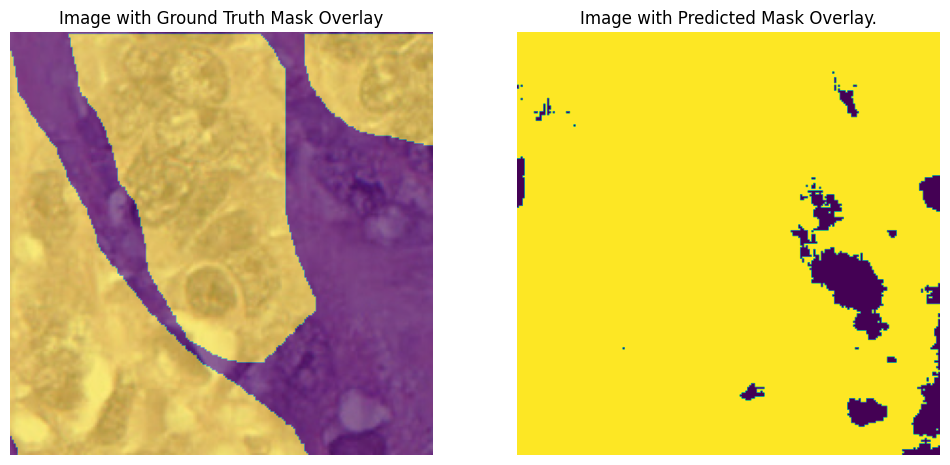

np.float64(0.79)

In [12]:
def plot_img(image_file, mask=None, pred=None):
    image_path = os.path.join("data/BCSS_small/val/",image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if mask is None :
        mask,pred = get_groundtruth_mask(image_file)
    dice_coff = dice_coef(mask, pred) 

    mask_np = mask.squeeze().numpy()  # Remove channel dimension and convert to numpy array
    pred_np = pred.squeeze().numpy()
    plt.figure(figsize=(12, 6))

    # Plot GT mask
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.imshow(mask_np, alpha=0.6) 
    plt.title('Image with Ground Truth Mask Overlay')
    plt.axis('off')

    # Plot image with mask overlay
    plt.subplot(1, 2, 2)
#    plt.imshow(image)
    plt.imshow(pred_np, alpha=1)  # Alpha controls the transparency
    plt.title('Image with Predicted Mask Overlay.')
    plt.axis('off')

    plt.show()
    return dice_coff
plot_img("TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_2016_size224.png")

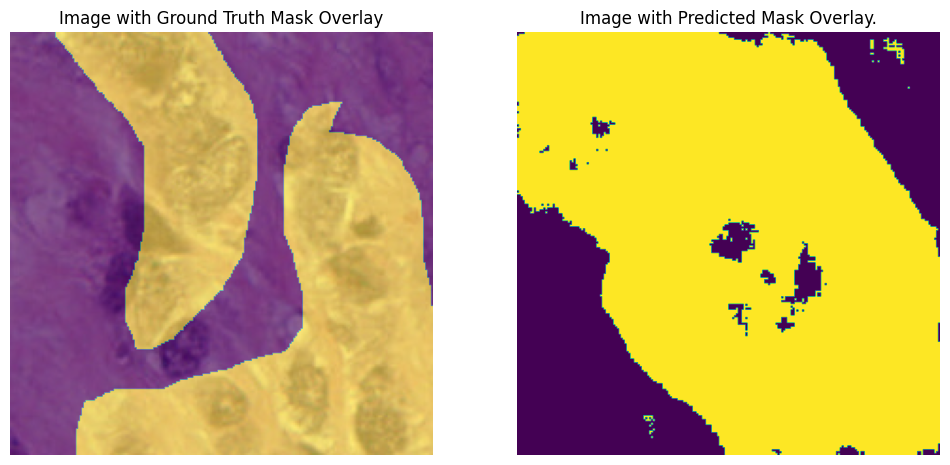

np.float64(0.744)

In [29]:
plot_img("TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_1344_2464_size224.png")

In [13]:
mask_path = "data/BCSS_small/val_mask/"
# mask_images = [os.path.join(image_path, filename) for filename in os.listdir(mask_path)]
dice_coff_list = []
for mask_image in os.listdir(mask_path):
    mask,pred = get_groundtruth_mask(mask_image)
    dice_coff_list.append(dice_coef(mask, pred))

In [14]:
dice_coff_list

[np.float64(0.79),
 np.float64(0.849),
 np.float64(0.764),
 np.float64(0.798),
 np.float64(0.744),
 np.float64(0.971),
 np.float64(0.463),
 np.float64(0.935),
 np.float64(0.0),
 np.float64(0.811),
 np.float64(0.814),
 np.float64(0.928),
 np.float64(0.877),
 np.float64(0.938),
 np.float64(0.661),
 np.float64(0.894),
 np.float64(0.0),
 np.float64(0.871),
 np.float64(0.93)]

In [ ]:
import argparse
import requests
from datetime import datetime

# Update this URL to your server's URL if hosted remotely
API_URL = "http://127.0.0.1:8000/predict"

def send_generate_request(image, x, y):

    response = requests.post(API_URL, files={"image": image, "x":  (None, x), "y":  (None, y)})
    if response.status_code == 200:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S").lower()
        filename = f"output-{timestamp}.png"
        
        with open(filename, "wb") as output_file:
            output_file.write(response.content)
        
        print(f"Image saved to {filename}")
    else:
        print(f"Error: Response with status code {response.status_code} - {response.text}")


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Send text & image to Pixtral server and receive a response.")
    parser.add_argument("--image", required=True, help="URL for the image file")
    parser.add_argument("--x", required=True, help="X coord of the item")
    parser.add_argument("--y", required=True, help="Y coord of the item")
    args = parser.parse_args()
    
    send_generate_request(args.image, args.x, args.y)

In [8]:
request= (('p1', '(200,1300)'), ('p2', '3900,a'), ('alpha', '0.3'), ('model', 'sam-vit_h'))
try:
    point1 = tuple(map(int, '(200,1300)'.strip('()').split(','))) 
    point2 = tuple(map(int, '3900,a'.strip('()').split(',')))
    print(point1)
    print(point2)
except Exception as e:
    print(e)
alpha = float(request["alpha"]) if "alpha" in request else None
model = request["model"] if "model" in request else "med_sam-vit_b"
if point1 and not is_tuple_of_ints(point1):
    print("Invalid point input. p1={}".format(point1))
elif (not point1 and point2) or (point2 and not is_tuple_of_ints(point2)):
    print("Invalid box input. p2={}")


invalid literal for int() with base 10: 'a'


NameError: name 'is_tuple_of_ints' is not defined